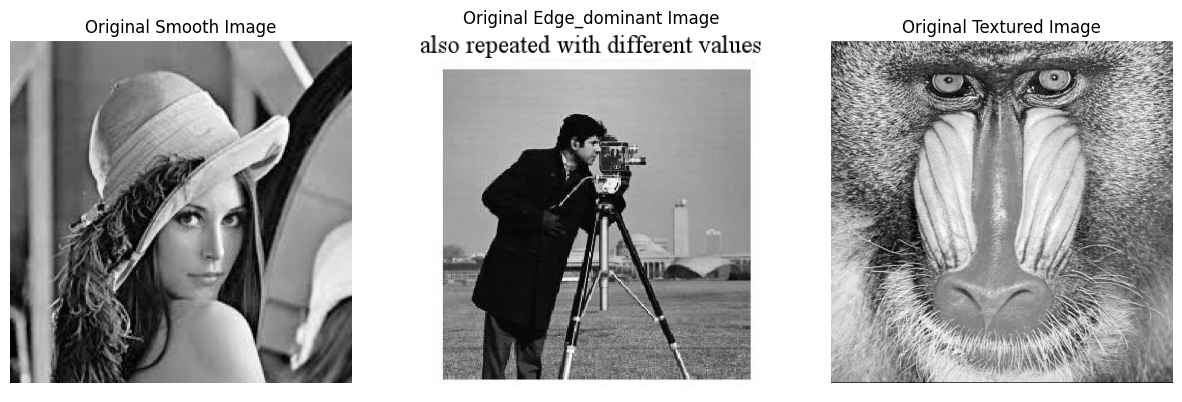

In [2]:
#TASK 1
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def load_local_image(path):
    """Loads an image from a local path, converts it to grayscale, and returns as a NumPy array."""
    try:
        # Open image, convert to grayscale ('L' mode), and then to a float numpy array
        img = Image.open(path).convert('L')
        return np.array(img, dtype=float)
    except FileNotFoundError:
        print(f"Error: Image not found at {path}")
        return None
    except Exception as e:
        print(f"Error processing image {path}: {e}")
        return None

# Paths to your uploaded images
# Make sure these file names match exactly what you uploaded.
image_paths = {
    "smooth": "Smooth_Image.jpeg",
    "edge_dominant": "Edge_dominant_image.png",
    "textured": "Textured_image.ppm"
}

# Load images into a dictionary
images = {name: load_local_image(path) for name, path in image_paths.items()}

# Display the original grayscale images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, name in zip(axes, images):
    if images[name] is not None:
        ax.imshow(images[name], cmap='gray')
        ax.set_title(f"Original {name.capitalize()} Image")
    else:
        ax.set_title(f"{name.capitalize()} Image\n(Load Failed)")
    ax.axis('off')
plt.show()

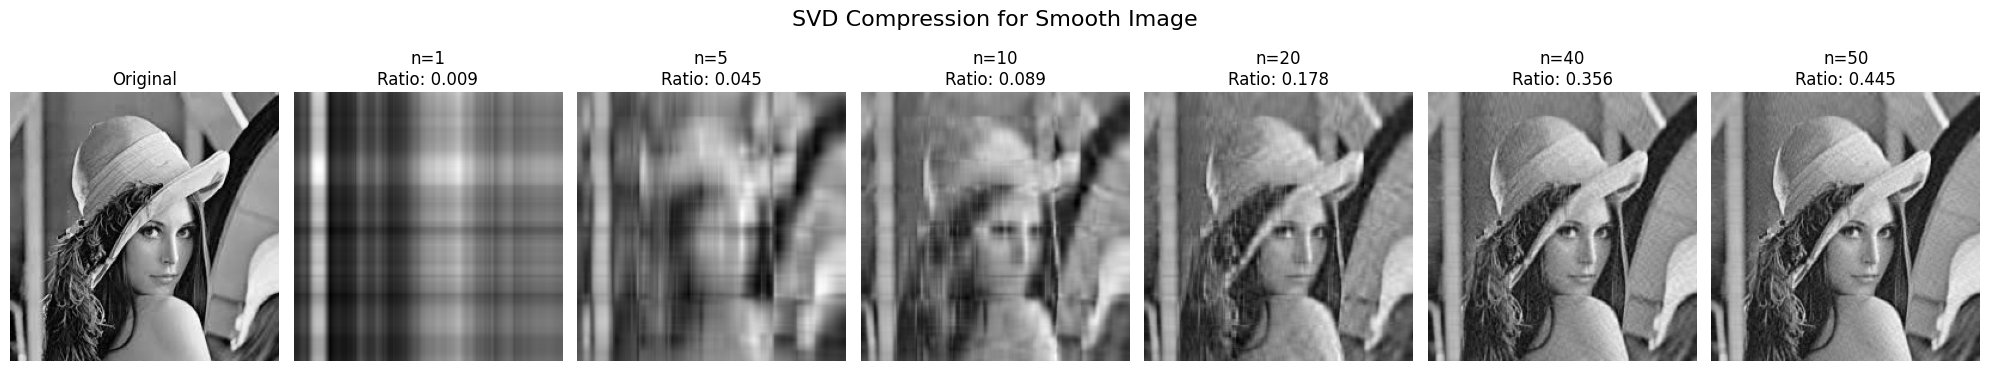

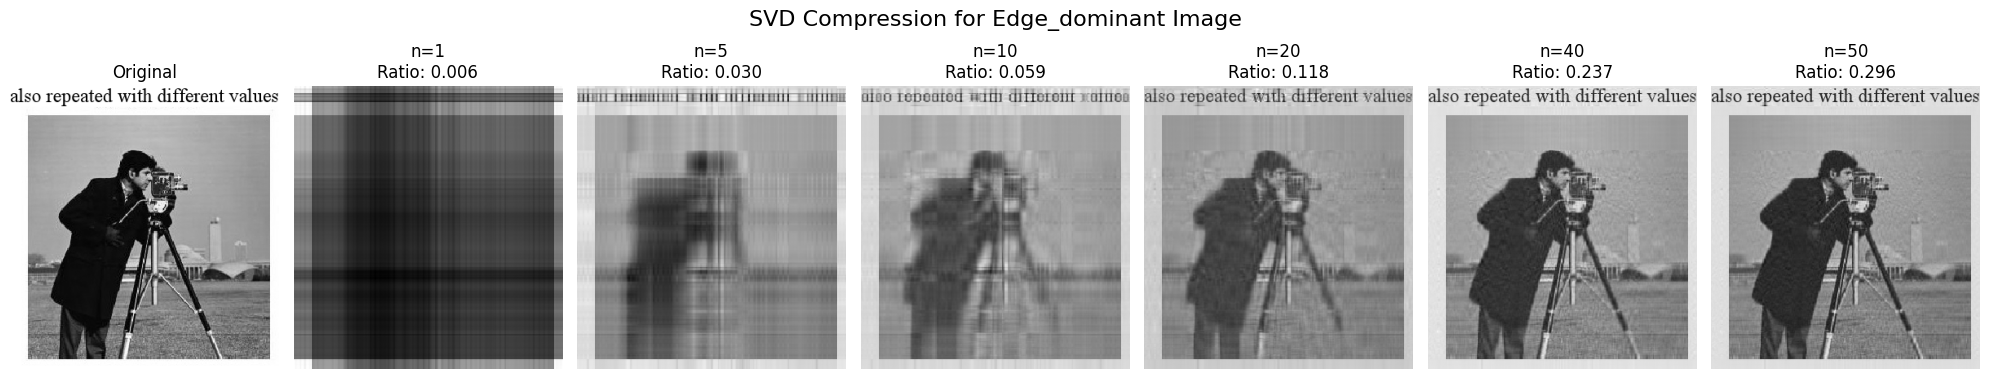

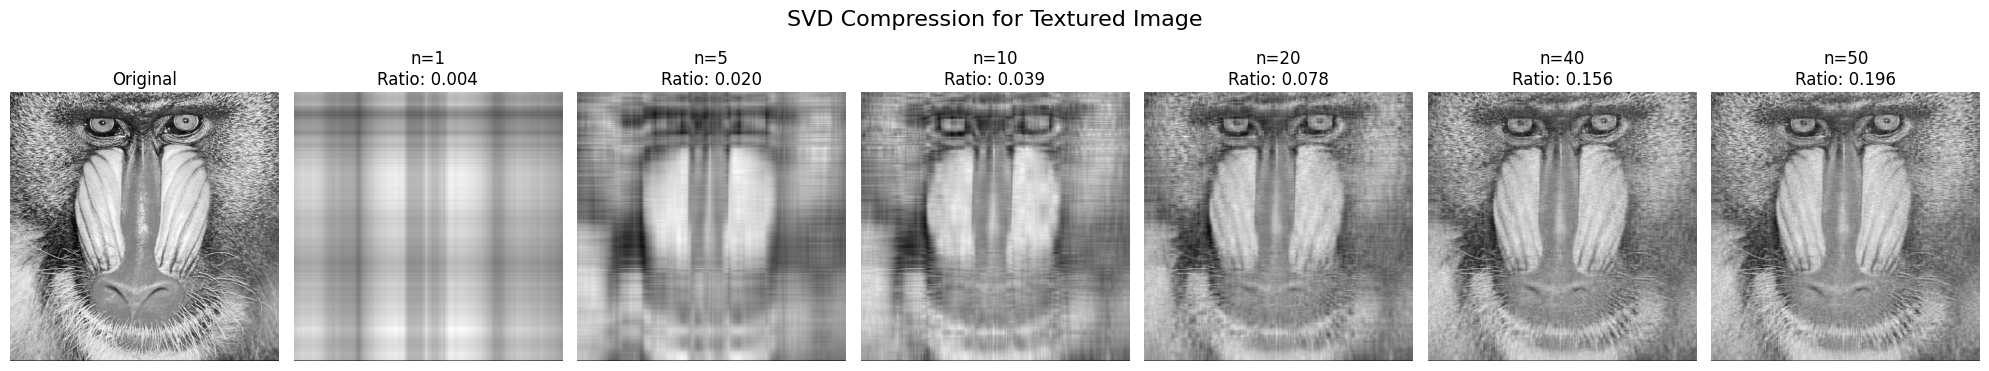

In [5]:
#TASK2
def reconstruct_image(image_matrix, n):
    """
    Performs SVD on an image and reconstructs it using the top n singular values.
    """
    # Perform Singular Value Decomposition
    U, s, VT = np.linalg.svd(image_matrix, full_matrices=False)
    
    # Reconstruct the image using only the first n singular values
    # We create a diagonal matrix from the first n values of s,
    # and use the first n columns of U and first n rows of VT.
    reconstructed = U[:, :n] @ np.diag(s[:n]) @ VT[:n, :]
    
    return reconstructed

def calculate_compression_ratio(image_shape, n):
    """Calculates the storage ratio of the compressed vs. original image."""
    M, N = image_shape
    original_size = float(M * N)
    # Compressed data: n singular values + n columns of U (M*n) + n rows of VT (n*N)
    compressed_size = float(n * (M + N + 1))
    # Ratio < 1 means compression
    return compressed_size / original_size

# Values of n to test as per the lab manual
n_values = [1, 5, 10, 20, 40, 50]

# Perform and visualize the analysis for each image
for name, img in images.items():
    if img is not None:
        fig, axes = plt.subplots(1, len(n_values) + 1, figsize=(20, 4))
        
        # Plot the original image
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title("Original")
        axes[0].axis('off')
        
        # Plot reconstructions for different n
        for i, n in enumerate(n_values):
            # Ensure n does not exceed the number of possible singular values
            if n > min(img.shape):
                axes[i+1].set_title(f"n={n} (Too Large)")
                axes[i+1].axis('off')
                continue

            reconstructed_img = reconstruct_image(img, n)
            compression = calculate_compression_ratio(img.shape, n)
            
            axes[i+1].imshow(reconstructed_img, cmap='gray')
            axes[i+1].set_title(f"n={n}\nRatio: {compression:.3f}")
            axes[i+1].axis('off')
            
        fig.suptitle(f"SVD Compression for {name.capitalize()} Image", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

Loading MNIST dataset... (This might take a minute)
Dataset loaded successfully.


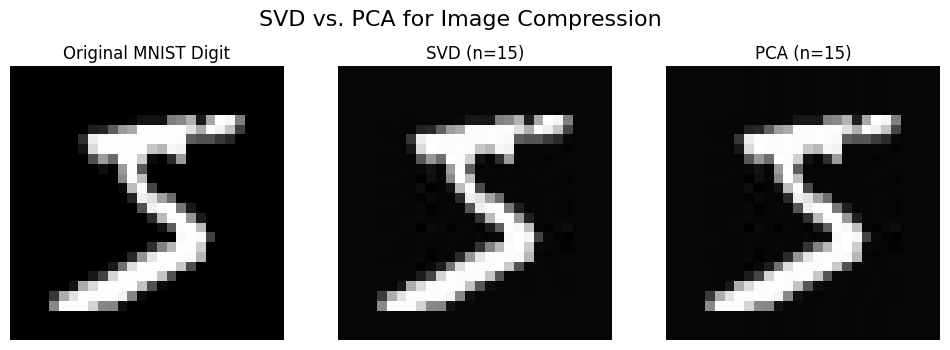

In [6]:
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml

# Load the MNIST dataset from scikit-learn
print("Loading MNIST dataset... (This might take a minute)")
try:
    mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
    X = mnist.data
    print("Dataset loaded successfully.")

    # Take one sample image (the first image is a '5') and reshape it to 28x28
    sample_image = X[0].reshape(28, 28)

    # Number of components to use for the comparison
    n_components = 15

    # 1. Reconstruct using our SVD function
    reconstructed_svd = reconstruct_image(sample_image, n_components)

    # 2. Reconstruct using scikit-learn's PCA
    pca = PCA(n_components=n_components)
    # PCA expects a 2D array where rows are samples. We fit it on our single image.
    pca_transformed = pca.fit_transform(sample_image)
    reconstructed_pca = pca.inverse_transform(pca_transformed)

    # 3. Visualize and compare the results
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(sample_image, cmap='gray')
    axes[0].set_title("Original MNIST Digit")
    axes[0].axis('off')

    axes[1].imshow(reconstructed_svd, cmap='gray')
    axes[1].set_title(f"SVD (n={n_components})")
    axes[1].axis('off')

    axes[2].imshow(reconstructed_pca, cmap='gray')
    axes[2].set_title(f"PCA (n={n_components})")
    axes[2].axis('off')

    plt.suptitle("SVD vs. PCA for Image Compression", fontsize=16)
    plt.show()

except Exception as e:
    print(f"Could not load MNIST dataset. Error: {e}")
    print("Please check your internet connection or try again later.")